### MACROS

In [1]:
WEIGHT_DECAY = 'weight_decay'
LEARNING_RATE = 'lr'

### IMPORTS

In [2]:
# !pip install albumentations

In [3]:
import os
import warnings
warnings.filterwarnings("ignore") # remove some scikit-image warnings

# import monai
# # monai.config.print_config()

from monai.apps import DecathlonDataset
from monai.data import DataLoader, CacheDataset, decollate_batch
# # from monai.data import decollate_patient_batch
# from monai.utils import first, set_determinism
from monai.networks.nets import UNet, DynUNet, AttentionUnet, ViTAutoEnc, UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric, MeanIoU, compute_average_surface_distance, DiceHelper
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
# import albumentations as A
from monai.transforms import (
    LoadImage,
    LoadImageD,
    EnsureChannelFirstD,
#     AddChannelD,
    ScaleIntensityD,
    ToTensorD,
    Compose,
    AsDiscreteD,
    SpacingD,
    OrientationD,
    ResizeD,
    RandAffineD,
    AsDiscrete,
    AsDiscreted,
    EnsureTyped,
    EnsureType,
    LoadImageD,
    EnsureChannelFirstD,
    OrientationD,
    SpacingD,
    ScaleIntensity,
    ResizeD,
    RandAffineD,
    RandFlipD,
    RandRotateD,
    RandZoomD,
#     RandDeformD,
    ToTensorD,
    Activations, AsDiscrete
)

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader as TorchDataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import sys
from tqdm import tqdm
import pandas as pd
import pickle as pkl

from torch.utils.data.dataloader import default_collate

from hyperparams import *


In [4]:
from torch.utils.tensorboard import SummaryWriter


### HYPERPARAMS ###


In [5]:
### HYPERPARAMS ###
crt_dir = os.getcwd()
# datasets_path = f'/raid/CataChiru/MedicalDecathlonTensors/'
# datasets_path = f'./datasets/MedicalDecathlonJustLungs/'
# datasets_path = f'./datasets/MedicalDecathlonJustTumors/'
datasets_path = f'./datasets/MedicalDecathlonAugmentedTumors/'
# datasets_path = f'./datasets/MedicalDecathlonAugmentedTumors2/'
# datasets_path = f'./datasets/MedicalDecathlonClaheTumors/'

model_name = 'unet'
checkpoints_path = f'{crt_dir}/checkpoints/{model_name.upper()}/'

DEBUG_MODE = True


### MAIN ###

In [6]:
# Initialize torch and cuda
cuda = torch.cuda.is_available()

# Set device to 3rd GPU
# device = torch.device("cuda:2" if cuda else "cpu")

# Use all GPUs
device = torch.device("cuda" if cuda else "cpu")

num_workers = 4 if cuda else 1

print(f'You are using {device}')

print(f'Number of images in a stack: {NO_STACKED_IMGS}')

You are using cuda
Number of images in a stack: 64


In [7]:
device

device(type='cuda')

In [8]:
# Used to bypass this error: https://github.com/pytorch/pytorch/issues/113245
os.environ["CUDA_VISIBLE_DEVICES"]="3,2,1,0"

In [9]:
# torch.multiprocessing.set_start_method('spawn', force=True)

In [10]:
# Set random seed
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)


# DEBUG FUNCTIONALITIES

In [11]:
def debug_plot(img, mask):
    '''
    Plots the image and mask as two subplots, for how many stacked images there are
    '''

    # 6x2 subplots, with reduced vertical space
    
    fig, axes = plt.subplots(img.shape[-1], 2, figsize=(10, 10))


    for i in range(img.shape[-1]):
        axes[i, 0].invert_yaxis()
        axes[i, 1].invert_yaxis()
        axes[i, 0].imshow(img[0, ..., i], cmap='gray')
        axes[i, 1].imshow(img[0, ..., i], cmap='gray')
        axes[i, 1].imshow(mask[0, ..., i], alpha=0.5, cmap='jet')
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')

    plt.subplots_adjust(wspace=0)    
    plt.show()

def debug_plot_single(img, mask):
    a = img[0].to('cpu').detach().numpy()
    b = mask[0].to('cpu').detach().numpy()
    for i in range(img.shape[-1]):
        plt.imshow(a[0, ..., i], cmap = 'gray')
        plt.imshow(b[0, ..., i], cmap = 'jet', alpha = 0.5)
        plt.gca().invert_yaxis()
        # plt.gca().set_aspect('equal', adjustable='box')
        plt.gca().set_axis_off()
        plt.show()


### PREPROCESSING TRANSFORMS

In [12]:
# Used Dictionary transforms from MONAI to apply the same transforms to both the image and the label
train_transform = Compose([RandRotateD(range_x=0, range_y=0, range_z=np.pi/12, prob=1, keys=['image', 'label'])])
post_pred = Compose([AsDiscrete(argmax=True, to_onehot= 2)])

# DATA LOADER

In [13]:
def compute_tumour_percentage_per_patient(tumour):
    '''
    Computes the percentage of tumour in each patient
    '''

    return 100*np.sum(tumour) / np.prod(tumour.shape)

def build_stack_ordered_indices(split_type : str, slices_per_patient: [int], stack_size : int, tumours : list = None, upload_flag : bool = True ) -> list[tuple]:
    ''' Iterates an overlapping sliding window of stack_size images for each patient per batch.

    For split_type = 'training', the stacks are with an overlapping window from start to finish.
    Returns a list of tuples (patient_id, stack_indices, tumour_percentage, has_tumour, original_idx) 
    
    For split_type = 'validation', the stacks are built with a stride of "stack_size" over the entire volume of each patient, and the last stack is padded with the last slice of the volume up to "stack_size" slices.
    Returns a list of tuples (patient_id, stack_indices, tumour_percentage, has_tumour, original_idx) 


    '''
    stacks_in_order_indices =[]
    if split_type == "training":
        real_idx = 0
        # Saves the indices of the sliding window for each patient
        for patient_id, slices in tqdm(enumerate(slices_per_patient)):
            crt_slices = []

            for i in range(0, slices - stack_size + 1):
                    stacks_range = np.arange(i, i+stack_size)
                    crt_tumour = tumours[patient_id][1][..., i:i+stack_size]
                    tumour_percentage = compute_tumour_percentage_per_patient(crt_tumour)

                    crt_slices.append((patient_id, stacks_range, tumour_percentage, tumour_percentage > 0, real_idx))

                    real_idx += 1
            
            
            stacks_in_order_indices += crt_slices

    elif split_type == 'validation':

        for patient_id, slices in enumerate(slices_per_patient):
            # Non-overlapping sliding window of stack_size images, with stride = stack_size

            padding = stack_size - slices % stack_size
            remaining_difference = -1

            for i in range(0, slices, stack_size):
                remaining_difference = i + stack_size - slices
                if remaining_difference > 0:
                    break

                stacks_in_order_indices.append((patient_id, np.arange(i, i+stack_size)))

            # If the last stack is smaller than stack_size, we pad it with the last slice of the volume
            if padding  % stack_size != 0 and remaining_difference > 0:
                remaining_slices_indices = np.arange(i, slices)
                repeated_slices = np.repeat(slices - 1, padding)
                batch_indices = np.hstack((remaining_slices_indices, repeated_slices))
                stacks_in_order_indices.append((patient_id, batch_indices))


    if upload_flag and not os.path.exists(f'./ordered_{split_type}_indices_stack={stack_size}.pkl'):
        with open(f'./ordered_{split_type}_indices_stack={stack_size}.pkl', 'wb') as f:
            pkl.dump(stacks_in_order_indices, f)

    return stacks_in_order_indices


def create_oversampled_index_dataset(ordered_stacks, split_type, stack_size, print_flag = False, 
    tumour_percent_threshold : float = 0.5, tumorous_proportion : float = 0.7, upload_flag : bool = True,
    undersample_flag : bool = False, undersample_size : int = 300):
    '''
    Based on the threshold set for the tumour percentage, splits the dataset and oversamples the desired portion of the dataset
    Returns the complete list of indices by intercalating the two portions
    '''

    ordered_stacks.sort(key = lambda x: x[2], reverse = True)

    small_tumour_stacks = list(filter(lambda x: x[2] < tumour_percent_threshold, ordered_stacks))

    print("Small tumour stacks", len(small_tumour_stacks))

    # TODO shuffle tensor and keep only undersample_size
    if undersample_flag:
        np.random.shuffle(small_tumour_stacks)
        if undersample_size < len(small_tumour_stacks):
            small_tumour_stacks = small_tumour_stacks[:undersample_size]

    length_small_tumour_stacks = len(small_tumour_stacks)

    print("Small tumour stacks2", length_small_tumour_stacks)


    big_tumour_stacks = list(filter(lambda x: x[2] > tumour_percent_threshold, ordered_stacks))

    print("Big tumour stacks", len(big_tumour_stacks))

    length_big_tumour_stacks = len(big_tumour_stacks)

    oversampling_factor = int(length_small_tumour_stacks / ((1-tumorous_proportion) * length_big_tumour_stacks))
    if length_big_tumour_stacks < length_small_tumour_stacks and oversampling_factor > 1:
        big_tumour_stacks = big_tumour_stacks * oversampling_factor

    print("Small tumour stacks3", length_small_tumour_stacks)
    print("Big tumour stacks2", length_big_tumour_stacks)

    length = length_small_tumour_stacks + len(big_tumour_stacks)

    all_stacks = []

    small_tumour_idx = 0
    big_tumour_idx = 0
    
    for i in range(length):
        if i % 10 >= 7 and small_tumour_idx < length_small_tumour_stacks:
            all_stacks.append(small_tumour_stacks[small_tumour_idx])
            small_tumour_idx += 1

            if print_flag:
                print("Small", i, small_tumour_idx)
        else:
            if big_tumour_idx >= len(big_tumour_stacks):
                break

            all_stacks.append(big_tumour_stacks[big_tumour_idx])
            big_tumour_idx += 1
            if print_flag:
                print("Big", i, big_tumour_idx)

    if upload_flag and not os.path.exists(f'./{split_type}_indices_stack={stack_size}.pkl'):
        with open(f'./{split_type}_indices_stack=6.pkl', 'wb') as f:
            pkl.dump(all_stacks, f)

    np.random.shuffle(all_stacks)

    print("Length of the dataset", len(all_stacks))
    return all_stacks




In [14]:
def convert_labels_to_one_hot(labels: torch.Tensor, num_classes: int) -> torch.Tensor:
    ''' Converts a tensor of labels to a one-hot tensor in which each channel corresponds to a binary decision for each class from the original tensor.'''
    
    one_hot = torch.zeros((2*labels.shape[0], labels.shape[1], labels.shape[2], labels.shape[3])).to(labels.device)
    
    one_hot[0, :, :, :] = (labels == 0).squeeze(1).float()
    one_hot[1, :, :, :] = (labels != 0).squeeze(1).float()

    return one_hot

In [15]:
class msdDataset(Dataset):
    def __init__(self, dataset_folder, transform = None, stack_size = 6, tumour_percent_threshold = 0.5, tumorous_proportion = 0.7, undersample_flag = False, undersample_size = 300):
        '''Am stabilit stack_size la 6 pe baza discutiei cu Doamna Udrea care sugera intre 3 si 6 imagini in stack + EDA2
        
        
        self.patients - contains (image, label) pairs for each patient in the dataset
        self.stacks_in_order_indices - contains the tuples (patient_id, stack_indices, other relevant attributes based on split_type) for each stack in the dataset
        
        '''
        self.img_folder = dataset_folder + "images/"
        self.label_folder = dataset_folder + "labels/"
        self.no_patients = len(os.listdir(self.img_folder))
        self.stack_size = stack_size
        self.transform = transform

        split_type = 'training' if 'training' in dataset_folder else 'validation'

        # Flag that indicates we are working with the training dataset, we want to apply random rotations only for this split
        self.train_flag = split_type == 'training'

        print(split_type)
        self.patients = [self.get_img_and_label(i) for i in range(self.no_patients)]

        # If the indices for the dataset have been already built, load them, otherwise build them
        if os.path.exists(f'./ordered_{split_type}_indices_stack={stack_size}.pkl'):
            print(f'./ordered_{split_type}_indices_stack={stack_size}.pkl exists. Loading the ordered indices.')
            with open(f'./ordered_{split_type}_indices_stack={stack_size}.pkl', 'rb') as f:
                self.stacks_in_order_indices = pkl.load(f)
        else:
            print(f'./ordered_{split_type}_indices_stack={stack_size}.pkl does not exist. Building the ordered indices.')
            slices_per_patient = [self.patients[i][0].shape[-1] for i in range(self.no_patients)]
            self.stacks_in_order_indices = build_stack_ordered_indices(split_type, slices_per_patient, stack_size, self.patients, upload_flag = True)
            
        if split_type == 'training':
            if os.path.exists(f'./{split_type}_indices_stack={stack_size}.pkl'):
                print(f'./{split_type}_indices_stack={stack_size}.pkl exists. Loading the overall indices.')
                with open(f'./{split_type}_indices_stack={stack_size}.pkl', 'rb') as f:
                    self.stacks_in_order_indices = pkl.load(f)
            else:
                print(f'./{split_type}_indices_stack={stack_size}.pkl does not exist. Building the overall indices.')
                self.stacks_in_order_indices = create_oversampled_index_dataset(self.stacks_in_order_indices, split_type, stack_size, 
                                                                                tumour_percent_threshold = tumour_percent_threshold, tumorous_proportion = tumorous_proportion,
                                                                                undersample_flag=undersample_flag, undersample_size = undersample_size)
        

        # self.device = device
        self.length = len(self.stacks_in_order_indices)

    def __len__(self):
        return self.length

    def get_img_and_label(self, patient_id):
        ''' Helper function: For a specified patient returns its image and label stacks from the dataset '''

        img = torch.load(self.img_folder + f'patient_{patient_id}.pt')
        label = torch.load(self.label_folder + f'patient_{patient_id}.pt')
        return img, label

    def __getitem__(self, idx):
        # print(f'Getting item {idx}/{len(self)}')
        # print(self.img_folder + f'patient_{patient_id}.pt')

        # Based on current index, get the patient_id and the slices that form the current stack

        if idx >= 0 and idx < self.length:
            stacks_tuple = self.stacks_in_order_indices[idx]
            patient_id, chosen_stacks = stacks_tuple[0], stacks_tuple[1]

            img, label = self.patients[patient_id]
            # Filters the current stack of images and labels for the current batch
            img, label = img[..., chosen_stacks], label[..., chosen_stacks]

            if self.train_flag and self.transform and stacks_tuple[3]:
                output = self.transform({'image': img, 'label': label})
                img, label = output['image'], output['label']

            # label = convert_labels_to_one_hot(label, 2) # Not needed for now, as MONAI handles the conversion internally
            return img, label
        else:
            raise IndexError


In [16]:
train_name = "training/"
val_name = "validation/"

In [17]:
datasets_path

'./datasets/MedicalDecathlonAugmentedTumors/'

In [18]:
"Batch size: ", BATCH_SIZE

('Batch size: ', 16)

In [22]:
msd_train_dataset = msdDataset(datasets_path + train_name, transform = train_transform, tumour_percent_threshold=0.125, tumorous_proportion=0.5, undersample_flag=True, undersample_size=350)

training
./ordered_training_indices_stack=6.pkl does not exist. Building the ordered indices.


51it [00:18,  2.77it/s]

./training_indices_stack=6.pkl does not exist. Building the overall indices.
Small tumour stacks 1050
Small tumour stacks2 350
Big tumour stacks 887
Small tumour stacks3 350
Big tumour stacks2 887
Length of the dataset 1237


In [23]:
len(msd_train_dataset)

1237

torch.Size([1, 512, 512, 6]) torch.Size([1, 512, 512, 6])


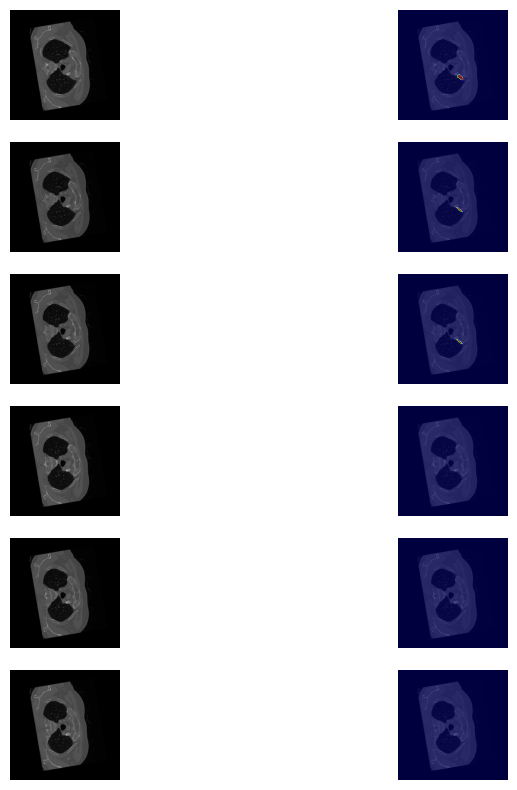

In [24]:
img, label = msd_train_dataset[0]

print(img.shape, label.shape)

output = train_transform({'image': img, 'label': label})

img_transformed, label_transformed = output['image'], output['label']

debug_plot(img_transformed, label_transformed)

In [25]:
msd_val_dataset = msdDataset(datasets_path + val_name, transform = None)

validation
./ordered_validation_indices_stack=6.pkl exists. Loading the ordered indices.


In [26]:
len(msd_train_dataset), len(msd_val_dataset)

(1237, 546)

In [27]:
train_loader = TorchDataLoader(msd_train_dataset, batch_size = BATCH_SIZE, shuffle = True, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) # TODO: Comment collate_fn if it doesn't work
val_loader = TorchDataLoader(msd_val_dataset, batch_size = BATCH_SIZE, shuffle = False, collate_fn=lambda x: tuple(x_ for x_ in default_collate(x))) #  num_workers = num_workers,

In [28]:
debug_img, debug_label = next(iter(train_loader))

In [29]:
debug_img.shape, debug_label.shape

(torch.Size([16, 1, 512, 512, 6]), torch.Size([16, 1, 512, 512, 6]))

In [30]:
input_channels = debug_img.shape[1]
output_channels = 2*input_channels

In [31]:
debug_img, debug_label = debug_img.to(device), debug_label.to(device)

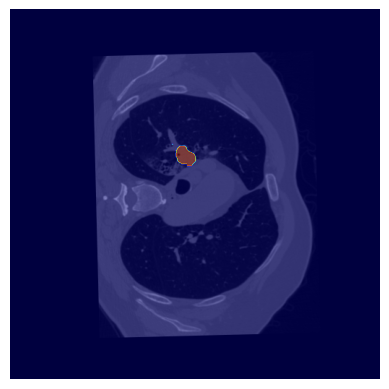

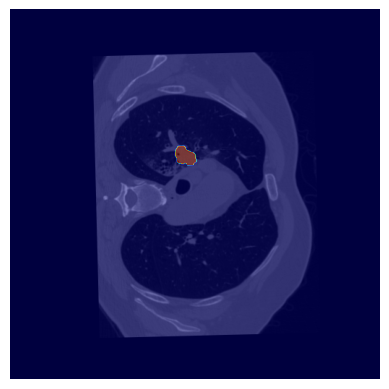

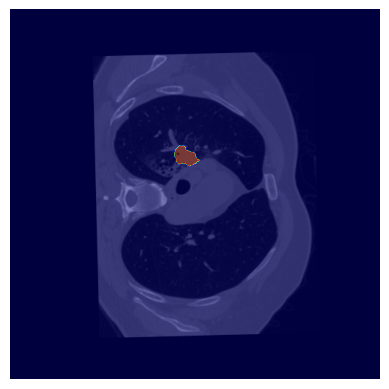

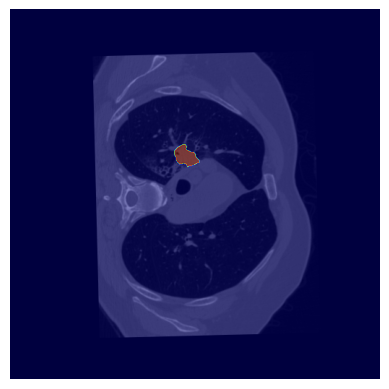

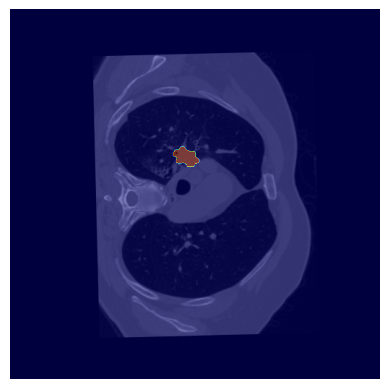

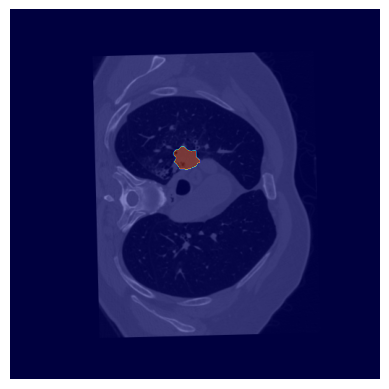

In [32]:
debug_plot_single(debug_img, debug_label)

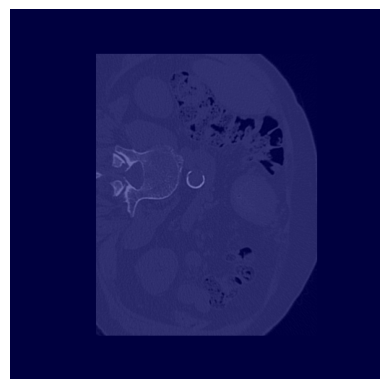

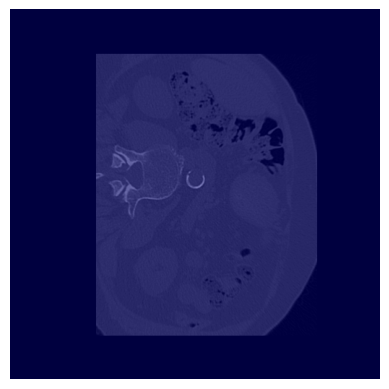

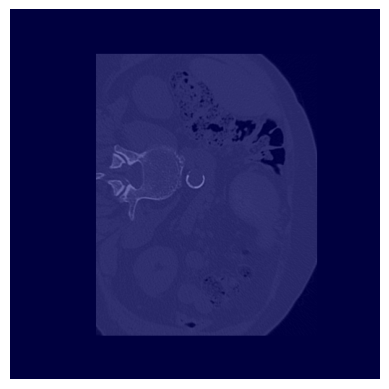

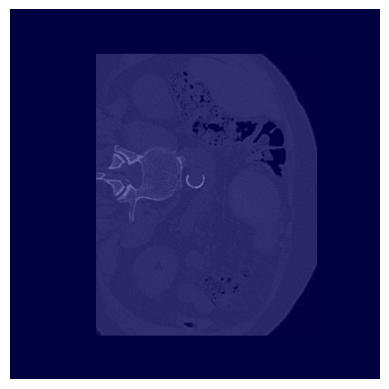

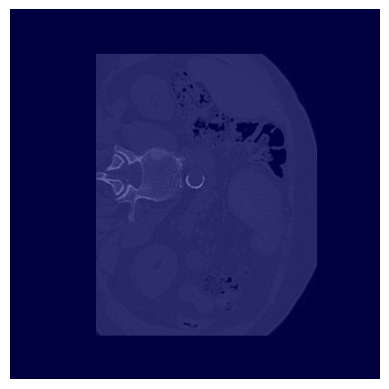

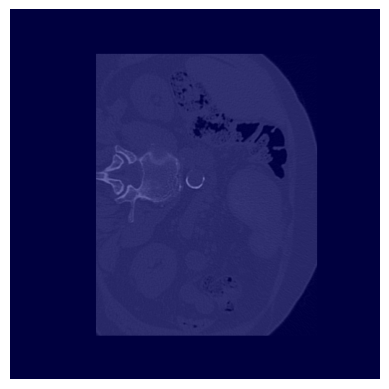

In [33]:
debug_img_val, debug_label_val = next(iter(val_loader))

debug_plot_single(debug_img_val, debug_label_val)

## MODEL

### MODEL HYPERPARAMS ###


In [34]:
# 100 EPOCHS:
# UNet_metadata = dict(
#     spatial_dims = 3,
#     in_channels = 1,
#     out_channels = 2,
#     channels = (16, 32, 32, 128),
#     kernel_size = (5, 5, 5),
#     strides = (1, 2, 1, 2),
#     num_res_units = 4,
#     norm = Norm.BATCH,
#     # act = torch.nn.ReLU,
#     dropout = 0.1
# )

UNet_metadata = dict(
    spatial_dims = 3,
    in_channels = 1,
    out_channels = 2,
    channels = (16, 32, 32, 128),
    kernel_size = (5, 5, 5),
    strides = (1, 2, 1, 2),
    num_res_units = 4,
    norm = Norm.BATCH,
    # act = torch.nn.ReLU,
    dropout = 0.1
)


In [35]:
best_previous_model_name = './checkpoints/UNET/min-max4_augmented_unet_nadam_lr5.00e-03_wd1.00e-04_diceloss_epoch16.pth'

In [36]:
# # Instantiate model
net = nn.Sequential(nn.BatchNorm3d(1, affine=True), UNet(**UNet_metadata), nn.InstanceNorm3d(2, affine=True))

net = nn.DataParallel(net, device_ids = [0, 1, 2, 3])
net = net.to(device)
# net.load_state_dict(torch.load(best_previous_model_name))

In [34]:
# See how much gpu the model 

In [37]:
debug_img.shape

torch.Size([16, 1, 512, 512, 6])

In [38]:
net(debug_img).shape

torch.Size([16, 2, 512, 512, 6])

In [39]:
### LOSS ###
loss_functions = {
    'dice': DiceLoss(to_onehot_y = True, softmax = True, include_background=False),
    'cross_entropy': nn.CrossEntropyLoss(),
    'custom': nn.BCELoss()
}

loss_key = 'dice'

loss_function = loss_functions[loss_key]


In [40]:
LEARNING_RATE = 5e-3

In [41]:
optimizers = { 'adam' : torch.optim.Adam, 'sgd' : torch.optim.SGD, 'nadam' : torch.optim.NAdam, 'rmsprop' : torch.optim.RMSprop, 'adamw' : torch.optim.AdamW}
optimizer_key = 'nadam'

# Instantiate optimizer
decayRate = 1  #- 1e-3
optimizer = optimizers[optimizer_key](net.parameters(), lr = LEARNING_RATE, weight_decay = 1e-4)

# Instantiate learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decayRate)


In [45]:
### PERFORMANCE METRICS ###
dice_metric = DiceHelper(include_background = False, reduction = "mean", get_not_nans=False, ignore_empty=True) # include_background = False,
iou_metric = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

### TRAINING PROCEDURE ###

In [46]:
def train(device, model, model_name, train_legth, train_loader, val_loader, loss_function, optimizer, lr_scheduler, MAX_EPOCHS=20, VALIDATION_INTERVAL=2, EPOCH_OFFSET : int = 0):

    lr_val = optimizer.defaults['lr']
    wd_val = optimizer.defaults[WEIGHT_DECAY]

    # Variables to get the best model
    best_dice = -1
    best_metrics = None
    best_metric_epoch = -1

    general_name = f'min-max5_augmented_{model_name}_{optimizer_key}_lr{lr_val:.2e}_wd{wd_val:.2e}_{loss_key}loss'
    best_model_name = checkpoints_path + f'{general_name}_best.pth'

    print(best_model_name)
    writer = SummaryWriter(log_dir=f"./pytorch_logging/{general_name}_epochs{MAX_EPOCHS}")


    # Evaluation metrics per epoch
    dice_values = []
    iou_values = []

    epoch_loss_values = []

    for epoch in range(1 + EPOCH_OFFSET, MAX_EPOCHS + 1):
        print("-" * 12)
        print(f"Epoch {epoch}/{MAX_EPOCHS}")

        # Turn model to "train" mode
        model.train()

        epoch_loss = 0
        for step, batch_data in enumerate(train_loader):
            step += 1

            train_input, label = batch_data
            train_input, label = train_input.to(device), label.to(device)

            output = model(train_input)

            loss = loss_function(output, label)
            loss.backward() # Compute gradient
            optimizer.step() # Update model's parameters

            epoch_loss += loss.item()
            print(f"{step}/{train_legth // train_loader.batch_size}, "
                f"train_loss: {loss.item():.4f}")

        epoch_loss /= step
        epoch_loss_values.append(epoch_loss)
        writer.add_scalar('Loss/train', epoch_loss, epoch)

        print(f"epoch {epoch} average loss: {epoch_loss:.4f}")

        if epoch % VALIDATION_INTERVAL == 0:
            # Save current checkpoint of the network

            print(f"Saving checkpoint: {epoch//VALIDATION_INTERVAL + 1} / {MAX_EPOCHS//VALIDATION_INTERVAL}!!!")
            name = checkpoints_path + f'{general_name}_epoch{epoch}.pth'
            torch.save(model.state_dict(), name)


            # Decay learning rate
            lr_scheduler.step()

            # Turn model to "eval" mode
            model.eval()


            # Disabling gradient calculation is useful for inference, when you are sure that you will not call Tensor.backward().
            # It will reduce memory consumption for computations that would otherwise have requires_grad=True
            with torch.no_grad():
                iteration_dice = []
                # iteration_ious = []
                # iteration_pixel_accuracies = []
                # iteration_rvds = []

                for val_data in val_loader:
                    val_input, val_label = val_data
                    val_input, val_label = val_input.to(device), val_label.to(device)

                    val_output = model(val_input)
                    val_output = nn.Softmax(dim=1)(val_output)

                    # Compute metrics for current iteration
                    iteration_dice.append(dice_metric(y_pred = val_output, y = val_label).item())
                    iou_metric(y_pred= val_output, y=val_label)

            # Aggregate the final mean results
            dice_score = torch.mean(torch.tensor(iteration_dice)).item()
            mean_iou = iou_metric.aggregate().item()

            # Reset the status for the next epoch
            # dice_metric.reset()
            iou_metric.reset()

            dice_values.append(dice_score)
            iou_values.append(mean_iou)

            writer.add_scalar('Dice/val', dice_score, epoch)
            writer.add_scalar('IoU/val', mean_iou, epoch)

            if dice_score > best_dice:
                best_dice = dice_score
                best_metrics = (dice_score, mean_iou)
                best_metric_epoch = epoch + 1
                print("saved new best metric model!!!")

                torch.save(model.state_dict(), best_model_name)

            print(
                f"current epoch: {epoch + 1},"
                f" current mean dice: {dice_score:.4f},"
                f" current mean iou: {mean_iou:.4f},"
                f" best mean dice: {best_dice:.4f},"
                f" at epoch: {best_metric_epoch}"
            )

    print(
        f"train completed, metrics correspondic to best dice are: dice: {best_metrics[0]:.4f}, iou: {best_metrics[1]:.4f}" #, acc: {best_metrics[2]:.4f}, rvd: {best_metrics[3]:.4f}"
        f" at epoch: {best_metric_epoch}"
    )

    with open(checkpoints_path + f'{general_name}_metrics_evolution.pkl', 'wb') as f:
        pkl.dump((dice_values, iou_values, epoch_loss_values), f)

    writer.close()

    return best_model_name


In [48]:
best_model_name = train(device, net, model_name, len(msd_train_dataset), train_loader, val_loader, loss_function, optimizer, lr_scheduler, MAX_EPOCHS=100, VALIDATION_INTERVAL=2, EPOCH_OFFSET=2)

/home/aimas/Desktop/Disertatie_CataChiru/LungCancerCT/checkpoints/UNET/min-max5_augmented_unet_nadam_lr5.00e-04_wd1.00e-04_diceloss_best.pth
------------
Epoch 3/100
1/77, train_loss: 0.9828
2/77, train_loss: 0.9873
3/77, train_loss: 0.9772
4/77, train_loss: 0.9809
5/77, train_loss: 0.9859
6/77, train_loss: 0.9811
7/77, train_loss: 0.9809
8/77, train_loss: 0.9814
9/77, train_loss: 0.9849
10/77, train_loss: 0.9685
11/77, train_loss: 0.9897
12/77, train_loss: 0.9778
13/77, train_loss: 0.9874
14/77, train_loss: 0.9801
15/77, train_loss: 0.9867
16/77, train_loss: 0.9870
17/77, train_loss: 0.9826
18/77, train_loss: 0.9917
19/77, train_loss: 0.9832
20/77, train_loss: 0.9924
21/77, train_loss: 0.9681
22/77, train_loss: 0.9788
23/77, train_loss: 0.9888
24/77, train_loss: 0.9798
25/77, train_loss: 0.9866
26/77, train_loss: 0.9824
27/77, train_loss: 0.9865
28/77, train_loss: 0.9848
29/77, train_loss: 0.9772
30/77, train_loss: 0.9887
31/77, train_loss: 0.9769
32/77, train_loss: 0.9743
33/77, trai

KeyboardInterrupt: 

In [55]:
# Get net weights
net.state_dict()

OrderedDict([('module.0.weight', tensor([-17.1406], device='cuda:0')),
             ('module.0.bias', tensor([-18.7823], device='cuda:0')),
             ('module.0.running_mean', tensor([0.0990], device='cuda:0')),
             ('module.0.running_var', tensor([0.0240], device='cuda:0')),
             ('module.0.num_batches_tracked', tensor(5271, device='cuda:0')),
             ('module.1.model.0.conv.unit0.conv.weight',
              tensor([[[[[ 20.8129,  14.8019,  13.0168,  12.1708,   6.1583],
                         [ 22.2486,  17.8555,  13.9881,   8.9225,   1.0935],
                         [ 23.0363,  20.4537,  16.3190,   8.6893,  -2.4690],
                         [ 22.7183,  21.3372,  18.6801,  10.1761,  -4.4001],
                         [ 21.8498,  21.1285,  20.1021,  12.0780,  -4.2968]],
              
                        [[ 25.2315,  19.0553,  13.9645,  13.0636,   7.9597],
                         [ 26.2336,  23.1529,  16.1454,  10.1641,   3.4897],
                     

In [48]:
5.6441 == 56441 / 10000

True

In [ ]:
best_model_name = './checkpoints/UNET/min-max_augmented_unet_nadam_lr5.00e-03_wd1.00e-03_diceloss_epoch82.pth'

In [ ]:
%load_ext tensorboard
%reload_ext tensorboard

%tensorboard --logdir=./pytorch_logging/unet_adam_lr3.00e-03_diceloss_epochs50/

### VALIDATION PROCEDURE ###

In [ ]:
val_net = net

In [ ]:
# TODO: Verificat dupa ce rezolv restul lucrurilor de ce nu merge loadul ca lumea
val_net = nn.Sequential(nn.BatchNorm3d(1, affine=True), UNet(**UNet_metadata), nn.InstanceNorm3d(2, affine=True))
val_net = nn.DataParallel(val_net, device_ids = [0, 1, 2, 3])
val_net = val_net.to(device)
val_net.load_state_dict(torch.load(best_model_name))


In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - VALIDATION LOADER #
for val_data1 in val_loader:
    val_input1, val_label1 = val_data1
    break


they_are_ordered = True

for i in range(val_input1.shape[0]):
    they_are_ordered &= (val_input1[i][0] == msd_val_dataset[i][0]).all()

print(f"Same order test1: {they_are_ordered}")

i = 3
skipped_images = 0
for val_data2 in val_loader:
    if i > 0:
        i -= 1
        skipped_images += val_data2[0].shape[0]
        continue
    else:
        val_input2, val_label2 = val_data2
        break

print(f"No of skipped images: {skipped_images}")
for j in range(3*val_input2.shape[0], 4*val_input2.shape[0]):
    print("Index of image in batch: ", j % val_input2.shape[0], " || ", "Index of image in dataset: ", j)
    they_are_ordered &= (val_input2[j % val_input2.shape[0]][0] == msd_val_dataset[j][0]).all()

print(f"Same order test2: {they_are_ordered}")

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - LR SCHEDULER LOADER #
future_lr1 = lr_scheduler.get_last_lr()[0] * decayRate

lr_scheduler.step()
future_lr2 = lr_scheduler.get_last_lr()[0]

print(f"LR works as expected: {future_lr1 == future_lr2}")

In [ ]:
def hard_threshold_labels(labels, threshold = 0.5, cutoff_flag = False):
    '''Thresholds the labels to 0 or 1 based on a specified threshold.'''

    sigmoid_activation = Activations(sigmoid=True)

    labels = sigmoid_activation(labels)


    if cutoff_flag:
        hard_thresholding = AsDiscrete(threshold=threshold)
        mask_from_background = (1 - labels[1])
        mask = labels[0]

        # Mean based on the two masks
        labels = (mask_from_background + mask) / 2
        max_value = torch.max(labels)
        min_value = torch.min(labels)

        if max_value > 0:
            labels = (labels - min_value) / (max_value - min_value)

        labels = hard_thresholding(labels)
        labels = np.expand_dims(labels, 0)
        # print(labels.shape)

    return labels

In [ ]:
def plot_prediction_label_side_by_side(img, label, prediction, threshold = 0.5):
    '''
    Plots a 2 x 3 grid with the image, label and prediction side by side on the first row.

    On the second row, the image is plotted with the label and prediction overlayed.
    '''

    for i in range(img.shape[0]):
        print(i)
        if i > 1:
            break
        im = img[i].to('cpu').detach().numpy()
        target = label[i].to('cpu').detach().numpy()
        output = prediction[i].to('cpu').detach().numpy()
        # output = hard_threshold_labels(output, threshold, cutoff_flag = False)

        for j in range(img.shape[-1]):
            fig, ax = plt.subplots(2, 3, figsize=(15, 5))

            ax[0, 0].imshow(im[0, ..., j], cmap = 'gray')
            ax[0, 1].imshow(target[0, ..., j], cmap = 'jet')
            im1 = ax[0, 2].imshow(output[1, ..., j], cmap = 'jet')
            ax[1, 0].imshow(im[0, ..., j], cmap = 'gray')
            ax[1, 1].imshow(im[0, ..., j], cmap = 'gray')
            ax[1, 1].imshow(target[0, ..., j], cmap = 'jet', alpha = 0.5)
            ax[1, 2].imshow(im[0, ..., j], cmap = 'gray')
            im2 = ax[1, 2].imshow(output[1, ..., j], cmap = 'jet', alpha = 0.5)

            plt.colorbar(im1, ax=ax[0, 2])
            plt.colorbar(im2, ax=ax[1, 2])  

            for k in range(2):
                for l in range(3):
                    ax[k, l].invert_yaxis()
                    ax[k, l].set_axis_off()

                    if k == 0:
                        ax[k, l].set_title(['Image', 'Label', 'Prediction'][l])
                    if i == 1:
                        ax[k, l].set_title(['Image', 'Label overlay', 'Prediction overlay'][l])


            # TODO: In alta zi, fa tight layout
            fig.tight_layout()
            plt.show()


In [ ]:
qualitative_plots_flag = False
save_qualitative_plots_flag = True

In [ ]:
### PERFORMANCE METRICS ###
dice_metric_eval = DiceHelper(include_background = False, reduction = "mean", get_not_nans=False, ignore_empty=True) # include_background = False,
iou_metric_eval = MeanIoU(include_background=False, reduction = "mean", get_not_nans=False, ignore_empty=True)

In [ ]:
if save_qualitative_plots_flag:
    if not os.path.exists('./plots'):
        os.mkdir('./plots')
        os.mkdir(f'./plots/{model_name.upper()}')
        os.mkdir(f'./plots/{model_name.upper()}/images')
        os.mkdir(f'./plots/{model_name.upper()}/gifs')

    if not os.path.exists(f'./plots/{model_name.upper()}'):
        os.mkdir(f'./plots/{model_name.upper()}')
        os.mkdir(f'./plots/{model_name.upper()}/images')
        os.mkdir(f'./plots/{model_name.upper()}/gifs')


In [ ]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)

    if total_pixel_truth == 0:
        return np.mean(1 - pred_mask)

    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

In [ ]:
no_val_iters = 0
loss_val = []
dice_val = []
iou_val = []
precision_val = []
recall_val = []

post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

save_val_data = []

with torch.no_grad():
    val_net.eval()

    count_plots = 0
    idx = 0

    for batch in val_loader:
        val_img, val_label = batch
        val_img, val_label = val_img.to(device), val_label.to(device)

        val_output = val_net(val_img)
        val_output = nn.Softmax(dim=1)(val_output)

        # roi_size = (512, 512, 2)
        # sw_batch_size = 1
        # val_outputs_dice = sliding_window_inference(val_img, roi_size, sw_batch_size, val_net)

        # val_outputs_dice = []
        # for val_crt_output in decollate_batch(val_outputs_dice):
        #     print(val_crt_output == None)
        #     print(val_crt_output.shape)
        #     val_outputs_dice.append(post_pred(nn.Softmax(dim=1)(val_crt_output)))

        # val_label_dice = []
        # for crt_label in decollate_batch(val_label):
        #     val_label_dice.append(post_label(crt_label))

        # compute metric for current iteration
        # dice_val.append(dice_metric_eval(y_pred=val_output, y=val_label).item())
        dice_val.append(dice_coef(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        precision_val.append(precision_score_(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        recall_val.append(recall_score_(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        iou_val.append(iou(val_label[1].to('cpu').detach().numpy(), val_output[1].to('cpu').detach().numpy()))
        iou_metric_eval(y_pred=val_output, y=val_label)
        # print("Dice score : ", dice_metric_eval.aggregate().item())
        # print("IoU score : ", iou_metric_eval.aggregate().item())
        # print("Loss : ", loss_function(val_output, val_label).item())

        # dice_val.append(dice_metric_eval.aggregate().item())
        # loss_val.append(loss_function(val_output, val_label).item())
        # iou_val.append(iou_metric_eval.aggregate().item())
        # no_val_iters += 1


        if recall_val[-1] > 0.8:
            save_val_data.append((val_img, val_label, val_output, recall_val[-1]))
        

        if qualitative_plots_flag:
            plot_prediction_label_side_by_side(val_img, val_label, val_output, threshold = 0.5)
            break

        if save_qualitative_plots_flag:

            for i in range(val_img.shape[0]):

                if idx == len(msd_val_dataset):
                    sys.exit()

                print(f"Current index: {idx} / {len(msd_val_dataset)}")
                # Don't save images for the padding indices
                # Only iterate through the unique slices for each patient
                patient_id, slices = msd_val_dataset.stacks_in_order_indices[idx]
                slices = np.unique(slices)
                
                if patient_id > 0:
                    sys.exit()

                im = val_img[i].to('cpu').detach().numpy()
                target = val_label[i].to('cpu').detach().numpy()
                output = val_output[i].to('cpu').detach().numpy()

                # Normalize the output to 0 or 1
                # output = hard_threshold_labels(output)

                idx += 1
                for j in range(len(slices)):
                    plt.imshow(im[0, ..., j], cmap = 'gray')
                    plt.imshow(output[1, ..., j], cmap = 'jet', alpha = 0.5)
                    plt.gca().invert_yaxis()
                    plt.gca().set_axis_off()

                    plt.savefig(f'./plots/{model_name.upper()}/images/patient{patient_id}_slice{slices[j]}.png')
                    plt.close()

    # Aggregate the final mean results
    dice_score_eval = torch.mean(torch.tensor(dice_val)).item()
    # mean_iou_eval = iou_metric_eval.aggregate().item()
    mean_iou_eval = torch.mean(torch.tensor(iou_val)).item()
    p_score_eval = np.mean(precision_val)
    r_score_eval = np.mean(recall_val)


    # # Reset the status
    # dice_metric_eval.reset()
    # iou_metric_eval.reset()

    print(f"Evaluation metrics: dice: {dice_score_eval:.4f}, iou: {mean_iou_eval:.4f}, precision: {p_score_eval:.4f}, recall: {r_score_eval:.4f}")

In [ ]:

for (val_img, val_label, val_output, crt_recall) in save_val_data:
    
    print(f'Recall score: {crt_recall}')
    for i in range(val_img.shape[-1]):
        im = val_img[0].to('cpu').detach().numpy()
        target = val_label[1].to('cpu').detach().numpy()
        output = val_output[1].to('cpu').detach().numpy()

        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
        axes[0].imshow(im[0, ..., i], cmap = 'gray')
        axes[0].imshow(target[0, ..., i], cmap = 'jet', alpha = 0.5)

        axes[1].imshow(im[0, ..., i], cmap = 'gray')
        axes[1].imshow(output[1, ..., i], cmap = 'jet', alpha = 0.5)

        for j in range(2):
            axes[j].invert_yaxis()
            axes[j].set_axis_off()
            

        plt.show()



In [ ]:
plt.plot(dice_val, label = 'Dice')
plt.plot(iou_val, label = 'IoU')
plt.plot(precision_val, label = 'Precision')
plt.plot(recall_val, label = 'Recall')
plt.plot(loss_val, label = 'Loss')
plt.legend()
plt.show()

In [ ]:
no_val_iters, len(dice_val)

In [ ]:
# IDIOT PROOF "IT WORKS WELL" TEST - MONAI ONE HOT ENCODING MAP #

from monai.networks.utils import one_hot
# Search for a slice with a tumour

for i in range(len(msd_val_dataset)):
    if(msd_val_dataset[i][1].sum() > 3000):
        single_label = msd_val_dataset[i][1].unsqueeze(0).to('cpu')
        print("OK")
        break

# See how the label looks like
plt.imshow(single_label[0, 0, ..., 3].to('cpu').detach().numpy(), cmap = 'gray')
plt.show()


print("ONE HOT ENCODING TEST")
# See how the one-hot encoding looks like splitted in background and tumour
one_hot_lbl = one_hot(single_label, 2)
one_hot_lbl = one_hot_lbl.detach().cpu().numpy()

plt.imshow(one_hot_lbl[0, 0, ..., 3], cmap = 'gray')
plt.show()
plt.imshow(one_hot_lbl[0, 1, ..., 3], cmap = 'gray')
plt.show()

### NUMBER OF TRAINABLE PARAMETERS

In [ ]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad:
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    # Get the total number of parameters as millions
    print(f"Total Trainable Params: {total_params/1e6:.2f} M params")
    return total_params
    
count_parameters(net)